### Loading the dataset using Kaggle API

In [13]:
!pip install kaggle

In [14]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
cp kaggle.json ~/.kaggle/

In [16]:
!kaggle datasets download -d snginh/teethdecay

 93% 15.0M/16.1M [00:01<00:00, 14.1MB/s]
100% 16.1M/16.1M [00:02<00:00, 8.46MB/s]


In [17]:
!unzip /content/teethdecay.zip

Archive:  /content/teethdecay.zip
  inflating: teeth_dataset/test.csv  
  inflating: teeth_dataset/test/caries/wc1.jpg  
  inflating: teeth_dataset/test/caries/wc1_0.jpg  
  inflating: teeth_dataset/test/caries/wc1_1.jpg  
  inflating: teeth_dataset/test/caries/wc1_10.jpg  
  inflating: teeth_dataset/test/caries/wc1_11.jpg  
  inflating: teeth_dataset/test/caries/wc1_12.jpg  
  inflating: teeth_dataset/test/caries/wc1_13.jpg  
  inflating: teeth_dataset/test/caries/wc1_14.jpg  
  inflating: teeth_dataset/test/caries/wc1_15.jpg  
  inflating: teeth_dataset/test/caries/wc1_16.jpg  
  inflating: teeth_dataset/test/caries/wc1_17.jpg  
  inflating: teeth_dataset/test/caries/wc1_18.jpg  
  inflating: teeth_dataset/test/caries/wc1_19.jpg  
  inflating: teeth_dataset/test/caries/wc1_2.jpg  
  inflating: teeth_dataset/test/caries/wc1_3.jpg  
  inflating: teeth_dataset/test/caries/wc1_4.jpg  
  inflating: teeth_dataset/test/caries/wc1_5.jpg  
  inflating: teeth_dataset/test/caries/wc1_6.jpg  
  

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
train_path = "/content/teeth_dataset/train/"
test_path = "/content/teeth_dataset/test"

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from glob import glob

## Getting contents of training and testing data

In [20]:
x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 945/945 [00:00<00:00, 1024.19it/s]


In [21]:
x_data = []
y_data = []

for category in glob(test_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 210/210 [00:00<00:00, 1136.55it/s]


# Model Building

In [22]:
train_generator = ImageDataGenerator(
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
test_generator = ImageDataGenerator(rescale=1./255.)

In [23]:
train_datagen = train_generator.flow_from_directory(
    train_path,
    batch_size=10,
    target_size=(224, 224)
)
test_datagen = test_generator.flow_from_directory(
    test_path,
    batch_size=10,
    target_size=(224, 224)
)

Found 1260 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


## Proposed CNN Model

In [24]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [26]:
hist_cnn = model.fit_generator(generator = train_datagen,epochs=20,validation_data = test_datagen)

Epoch 1/20
126/126 [==============================] - 36s 230ms/step - loss: 0.5884 - accuracy: 0.7437 - val_loss: 0.5945 - val_accuracy: 0.7143
Epoch 2/20
126/126 [==============================] - 21s 166ms/step - loss: 0.5572 - accuracy: 0.7500 - val_loss: 0.4899 - val_accuracy: 0.7143
Epoch 3/20
126/126 [==============================] - 19s 153ms/step - loss: 0.5307 - accuracy: 0.7468 - val_loss: 0.4130 - val_accuracy: 0.7279
Epoch 4/20
126/126 [==============================] - 19s 151ms/step - loss: 0.5016 - accuracy: 0.7659 - val_loss: 0.3808 - val_accuracy: 0.8163
Epoch 5/20
126/126 [==============================] - 21s 167ms/step - loss: 0.4910 - accuracy: 0.7683 - val_loss: 0.4674 - val_accuracy: 0.6973
Epoch 6/20
126/126 [==============================] - 19s 153ms/step - loss: 0.4853 - accuracy: 0.7675 - val_loss: 0.3599 - val_accuracy: 0.8027
Epoch 7/20
126/126 [==============================] - 19s 153ms/step - loss: 0.4548 - accuracy: 0.7881 - val_loss: 0.4001 - val_ac

## **Testing on Random Images**

In [56]:
import keras.utils as image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_res(path):
    raw_img = image.load_img(path, target_size=(224, 224))
    raw_img = image.img_to_array(raw_img)
    raw_img = np.expand_dims(raw_img, axis=0)
    raw_img = raw_img / 255
    predict = model.predict(raw_img)
    print(predict)
    bgr_img = cv2.imread(path)

    # Convert BGR to RGB
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(3, 2))
    ax.imshow(rgb_img)
    ax.axis('off')
    if predict[0][0] < 0.998:
        text = "Healthy tooth"
    elif 0.995 < predict[0][0] <= 0.999:
        text = "Mild Cavity (Enamel Decay)"
    elif 0.999 < predict[0][0] < 0.9998:
        text = "Moderate Cavity (Dentin Decay)"
    else:
        text = "Big Cavity (Pulp Decay)"
    plt.show()
    print("Image identified as "+text)

1/1 [==============================] - 0s 17ms/step
[[0.8786287  0.12137132]]


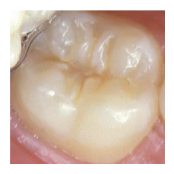

Image identified as Healthy tooth


In [58]:
path='/content/nc11.jpg'
get_res(path)

1/1 [==============================] - 0s 18ms/step
[[0.99885416 0.0011458 ]]


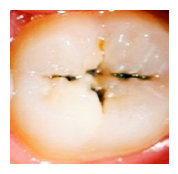

Image identified as Mild Cavity (Enamel Decay)


In [59]:
path='/content/wc58.jpg'
get_res(path)

1/1 [==============================] - 0s 18ms/step
[[9.9960655e-01 3.9345739e-04]]


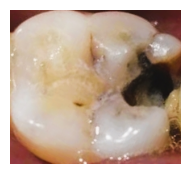

Image identified as Moderate Cavity (Dentin Decay)


In [60]:
path='/content/wc59.jpg'
get_res(path)

1/1 [==============================] - 0s 21ms/step
[[9.9999964e-01 3.5494415e-07]]


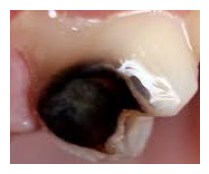

Image identified as Big Cavity (Pulp Decay)


In [61]:
path='/content/wc1.jpg'
get_res(path)